In [1]:
import bento
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
from hmr import Reloader

bento = Reloader(bento)

# Load seqFISH+ dataset

In [2]:
adata = bento.datasets.load_dataset("seqfish_raw")
adata

AnnData object with n_obs × n_vars = 211 × 9506
    obs: 'cell_shape', 'nucleus_shape', 'batch'
    uns: 'points'
    layers: 'spliced', 'unspliced'

# Quality Control

In [3]:
sc.pp.calculate_qc_metrics(adata, inplace=True, percent_top=None)
bento.tl.cell_area(adata)
bento.tl.cell_density(adata)

AnnData object modified:
    obs:
        + cell_area
AnnData object modified:
    obs:
        + cell_density


## Figure 1C

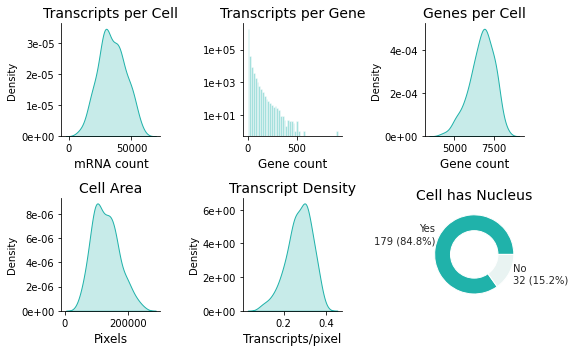

In [4]:
bento.pl.qc_metrics(adata)

Filter out cells without a nucleus.

In [5]:
adata = adata[adata.obs["nucleus_shape"] != None]
bento.pp.set_points(adata)

Trying to set attribute `.uns` of view, copying.


In [6]:
adata.shape

(179, 9506)

We will also filter genes and only include genes for which at least 10 molecules are detected in at least one cell. This helps reduce data sparsity for our downstream analysis, resulting in 3726 genes.

In [7]:
valid_genes = adata.var_names[(adata.to_df() >= 10).sum() >= 1]

adata = adata[:, valid_genes]
bento.pp.set_points(adata)

Trying to set attribute `.uns` of view, copying.


In [8]:
bento.reload()
bento.tl.analyze_samples(
    adata,
    [
        "cell_proximity",
        "nucleus_proximity",
        "cell_asymmetry",
        "nucleus_asymmetry",
        "ripley_stats",
        "point_dispersion",
        "nucleus_dispersion",
    ],
)
bento.tl.lp(adata, min_count=5)

Cell features:   0%|          | 0/3 [00:00<?, ?it/s]

AnnData object modified:
    obs:
        + cell_maxx, cell_radius, cell_miny, cell_raster, cell_maxy, cell_minx, cell_span
[########################################] | 100% Completed | 48min 16.7s
AnnData object modified:
    obs:
        + nuclear_count, nuclear_edge_count, cell_edge_fraction, none_fraction, none_count, fraction_detected, cytoplasmic_fraction, nuclear_fraction, cytoplasmic_count, cell_edge_count, nuclear_edge_fraction, n_detected
    var:
        + nuclear_count, nuclear_edge_count, cell_edge_fraction, none_fraction, none_count, fraction_detected, cytoplasmic_fraction, nuclear_fraction, cytoplasmic_count, cell_edge_count, nuclear_edge_fraction, n_detected
    layers:
        + none_p, cell_edge_p, nuclear_p, cell_edge, nuclear, none, nuclear_edge, cytoplasmic_p, nuclear_edge_p, cytoplasmic


## Figure 2

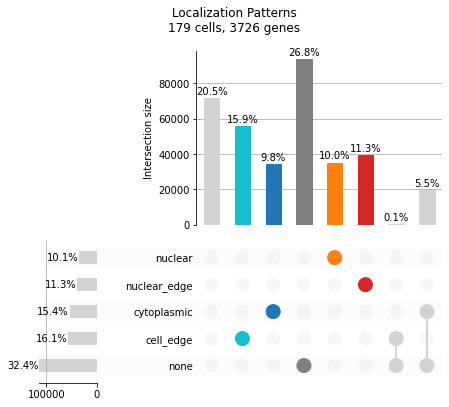

In [9]:
bento.pl.lp_dist(adata, percentage=True)

No handles with labels found to put in legend.


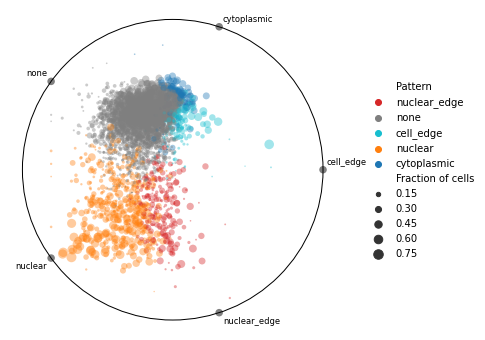

In [10]:
bento.pl.lp_genes(adata, alpha=0.4)

# Tensor decomposition

Device: cuda


  0%|          | 0/5 [00:00<?, ?it/s]

The rank at the elbow is: 3


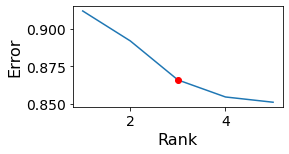

In [14]:
bento.reload()

bento.tl.select_tensor_rank(adata, bento.PATTERN_NAMES, upper_rank=5, runs=1)

In [16]:
bento.reload()
bento.tl.lp_signatures(adata, 3)

Device: cuda
AnnData object modified:
    obs:
        + td_cluster
    var:
        + td_cluster
    uns:
        + tensor_loadings


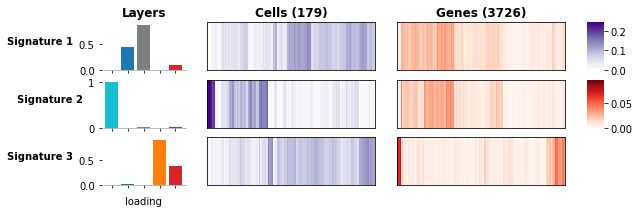

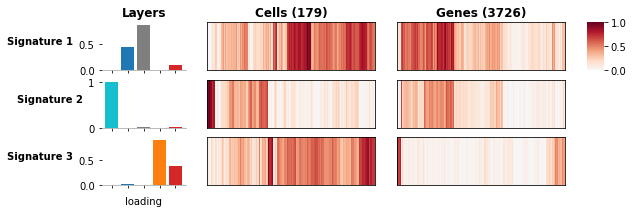

In [17]:
bento.pl.lp_signatures(adata, scale=False)
bento.pl.lp_signatures(adata, scale=True)

In [18]:
@bento.pl._utils.savefig
def plot_signature(data, id, fname=None):

    # Setup plot
    fig, axs = plt.subplots(
        2,
        4,
        figsize=(4, 3.6),
        gridspec_kw=dict(
            height_ratios=[1, 8], width_ratios=[1, 8, 0.5, 0.5], hspace=0, wspace=0
        ),
    )
    axs[0, 0].remove()
    axs[0, 2].remove()
    axs[0, 3].remove()
    axs[1, 2].remove()
    gene_ax = axs[0, 1]
    cell_ax = axs[1, 0]

    joint_ax = axs[1, 1]
    cbar_ax = axs[1, 3]

    gene_ax.xaxis.set_label_position("top")
    cell_ax.yaxis.set_label_position("left")

    joint_ax.sharex(gene_ax)
    joint_ax.sharey(cell_ax)

    cell_order = data.obs["td_cluster"].sort_values().index
    gene_order = data.var["td_cluster"].sort_values().index

    cell_loadings = np.log2(adata.uns["tensor_loadings"]["cells"] + 1)
    gene_loadings = np.log2(adata.uns["tensor_loadings"]["genes"] + 1)

    signature_mtx = np.dot(
        cell_loadings[id].values.reshape(-1, 1),
        gene_loadings[id].values.reshape(1, -1),
    )
    # signature_mtx = np.log2(signature_mtx + 1)
    signature_mtx = pd.DataFrame(
        signature_mtx, index=cell_loadings.index, columns=gene_loadings.index
    )
    signature_mtx = signature_mtx.loc[cell_order, gene_order]

    ar = np.sqrt(float(len(cell_loadings) / len(gene_loadings)))
    figsize = (10, 10 * ar)

    sns.heatmap(
        gene_loadings.loc[gene_order, [id]].T,
        cmap="Reds",
        ax=gene_ax,
        yticklabels=False,
        cbar=None,
        rasterized=True,
    )
    sns.heatmap(
        cell_loadings.loc[cell_order, [id]],
        cmap="Reds",
        ax=cell_ax,
        xticklabels=False,
        cbar=None,
        rasterized=True,
    )

    sns.heatmap(
        signature_mtx,
        cmap="Reds",
        xticklabels=False,
        yticklabels=False,
        cbar_ax=cbar_ax,
        ax=joint_ax,
        rasterized=True
        # figsize=figsize,
    )
    joint_ax.set(xlabel=None, ylabel=None)
    sns.despine(ax=gene_ax, top=False, bottom=False, left=False, right=False)
    sns.despine(ax=cell_ax, top=False, bottom=False, left=False, right=False)
    sns.despine(ax=joint_ax, top=False, bottom=False, left=False, right=False)

    plt.suptitle(id, weight="600")

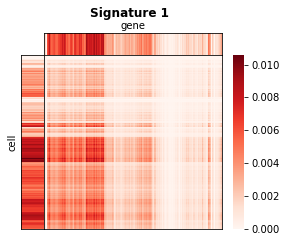

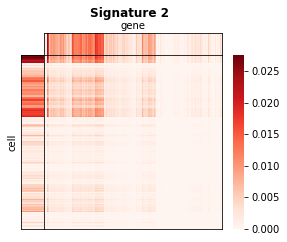

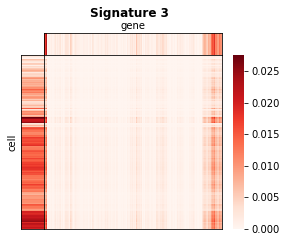

In [19]:
for sig, name in zip(
    adata.uns["tensor_loadings"]["layers"].columns, ["sig1", "sig2", "sig3"]
):
    plot_signature(adata, sig)

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

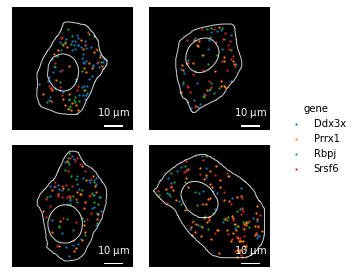

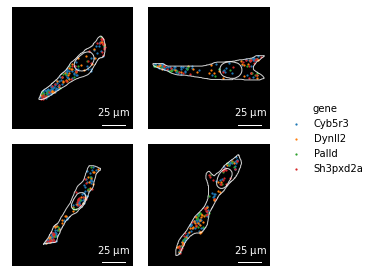

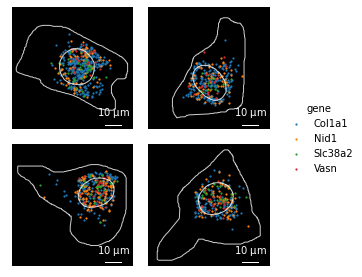

In [20]:
bento.pl.sig_samples(adata, n=4)

# Interpret gene loadings

In [21]:
gene_loadings = adata.uns["tensor_loadings"]["genes"]

## Gene set enrichment

In [22]:
import gseapy as gp
from scipy.stats import zscore

In [23]:
def gsea_top_pathways(gene_loadings, library):
    gene_loadings = gene_loadings.reset_index()
    gene_loadings["index"] = gene_loadings["index"].str.upper().astype(str)
    gene_loadings = gene_loadings.set_index("index")
    gene_loadings = gene_loadings.apply(zscore)

    top_enriched = []

    gsea_out = gp.ssgsea(
        gene_loadings,
        library,
        processes=8,
        min_size=50,
        no_plot=True,
        seed=6,
        verbose=True,
    )
    gsea_out.res2d.index = [i.split("(")[0] for i in gsea_out.res2d.index]
    top_enriched = []
    for f in gsea_out.res2d.columns:
        top_enriched.extend(gsea_out.res2d.sort_values(f).tail(5).index)

    top_enriched = list(set(top_enriched))

    plt.rcParams["figure.dpi"] = 100
    g = sns.clustermap(
        gsea_out.res2d.loc[top_enriched], cmap="RdBu_r", center=0, figsize=(6, 8)
    )
    # g.ax_heatmap.axis('on')
    g.ax_heatmap.tick_params(axis="both", which="both", length=0)
    g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xticklabels(), rotation=90)
    g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_yticklabels(), size=12)

### Loading enrichment

2022-06-28 15:14:19,789 Parsing data files for ssGSEA...........................
2022-06-28 15:14:20,629 Enrichr library gene sets already downloaded in: /cellar/users/ckmah/.cache/gseapy, use local file
2022-06-28 15:14:25,829 0469 gene_sets have been filtered out when max_size=2000 and min_size=50
2022-06-28 15:14:25,830 0042 gene_sets used for further statistical testing.....
2022-06-28 15:14:25,830 Start to run ssGSEA...Might take a while................
2022-06-28 15:14:36,127 Calculate Enrichment Score for Sample: Signature 1 
2022-06-28 15:14:36,128 Calculate Enrichment Score for Sample: Signature 2 
2022-06-28 15:14:36,129 Calculate Enrichment Score for Sample: Signature 3 
2022-06-28 15:14:36,130 Congratulations. GSEApy runs successfully................



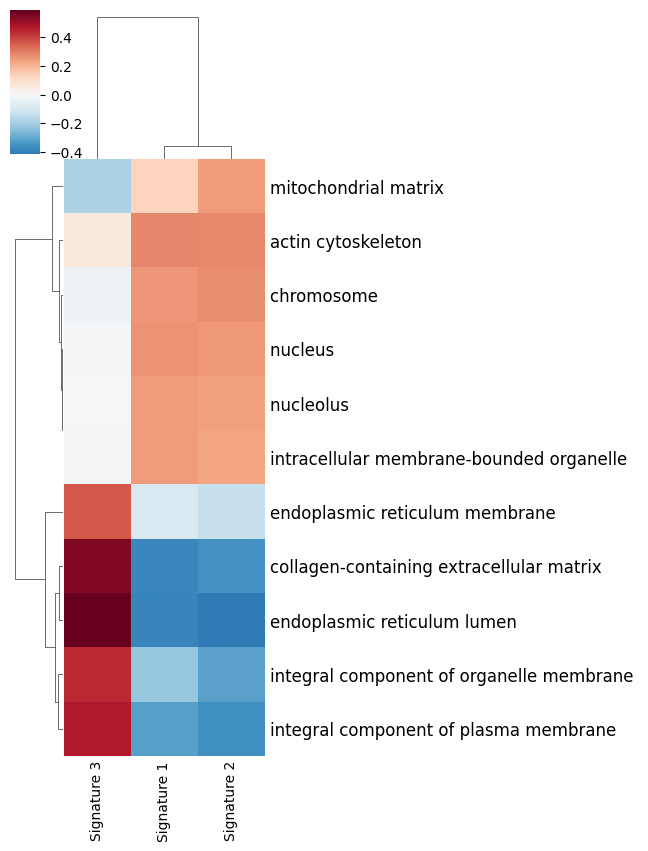

In [24]:
go_cc = gsea_top_pathways(gene_loadings, "GO_Cellular_Component_2021")

In [26]:
gene_loadings.index.name = None

2022-06-28 15:15:04,347 Parsing data files for ssGSEA...........................
2022-06-28 15:15:04,870 Enrichr library gene sets already downloaded in: /cellar/users/ckmah/.cache/gseapy, use local file
2022-06-28 15:15:09,988 0469 gene_sets have been filtered out when max_size=2000 and min_size=50
2022-06-28 15:15:09,989 0042 gene_sets used for further statistical testing.....
2022-06-28 15:15:09,989 Start to run ssGSEA...Might take a while................
2022-06-28 15:15:20,270 Calculate Enrichment Score for Sample: Signature 1 
2022-06-28 15:15:20,272 Calculate Enrichment Score for Sample: Signature 2 
2022-06-28 15:15:20,273 Calculate Enrichment Score for Sample: Signature 3 
2022-06-28 15:15:20,274 Congratulations. GSEApy runs successfully................



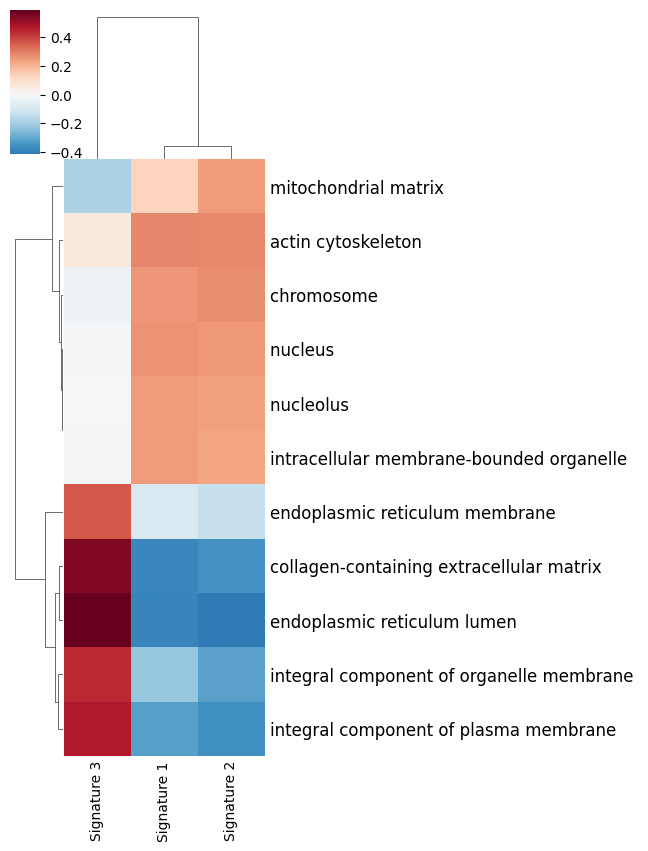

In [27]:
gsea_top_pathways(gene_loadings, "GO_Cellular_Component_2021")

# Interpet cell loadings

## morphology

In [28]:
from scipy.stats import zscore

In [29]:
cell_loadings = adata.uns["tensor_loadings"]["cells"]

In [30]:
cell_expr = adata.to_df()
cell_expr = np.log10(cell_expr[cell_expr >= 10] + 1).sum(axis=1).to_frame()
cell_expr.columns = ["log10(total cell expr)"]

expression = adata.to_df()
expression = np.log10(expression[expression >= 10] + 1).sum().to_frame()
expression.columns = ["log10(total cell expr)"]
expression.shape

(3726, 1)

In [31]:
morph_names = [
    "cell_perimeter",
    "cell_area",
    "cell_aspect_ratio",
    "nucleus_area",
    "nucleus_area_ratio",
    "nucleus_aspect_ratio",
    "nucleus_offset",
]
bento.tl.analyze_cells(adata, morph_names)
morph_features = adata.obs[morph_names]

  0%|          | 0/7 [00:00<?, ?it/s]

AnnData object modified:
    obs:
        + cell_perimeter, nucleus_aspect_ratio, cell_aspect_ratio, nucleus_offset, nucleus_area, nucleus_area_ratio


In [32]:
cell_measures = pd.concat([morph_features, cell_expr], axis=1).iloc[:, ::-1]

In [33]:
import pingouin as pg


def corr_loadings(loadings, phenotypes, height=6, aspect=0.5, fname=""):
    """
    Dotplot showing correlation of loadings to phenotypes.
    Hue denotes correlation, size denotes fraction of cells with phenotype.
    """
    data = pd.concat([loadings, phenotypes], axis=1)

    corr_long = data.pairwise_corr(
        columns=[loadings.columns.tolist(), phenotypes.columns.tolist()],
        method="spearman",
        padjust="holm",
    )[["X", "Y", "r", "p-unc", "p-corr"]]

    # -log10p for interpretation
    corr_long["-log10(fdr)"] = -np.log10(corr_long["p-corr"].astype(float) + 1e-3)
    corr_long["-log10(fdr)"] = (
        corr_long["-log10(fdr)"].map("{:,.2f}".format).astype(float)
    )

    with sns.axes_style("ticks"):
        g = sns.relplot(
            data=corr_long,
            x="X",
            y="Y",
            size="-log10(fdr)",
            sizes=(20, 800),
            size_norm=(0, 3),
            hue="r",
            hue_norm=(-1, 1),
            aspect=aspect,
            height=height,
            palette="RdBu_r",
            legend="auto",
        )

        ax = g.ax
        g.set(
            xlim=(-0.5, float(loadings.shape[1]) - 0.5),
            ylim=(-0.5, float(phenotypes.shape[1]) - 0.5),
            xlabel="",
            ylabel="",
        )
        ax.tick_params(axis="x", rotation=30)
        sns.despine(ax=ax, top=False, right=False)
        for spine in ax.spines.values():
            spine.set_edgecolor("black")
        ax.grid(visible=None, which="major", axis="both")
        # plt.tight_layout()

        rc = {"svg.fonttype": "none", "font.family": "Arial"}
        if fname:
            with plt.rc_context(rc):
                plt.savefig(fname)

    return corr_long

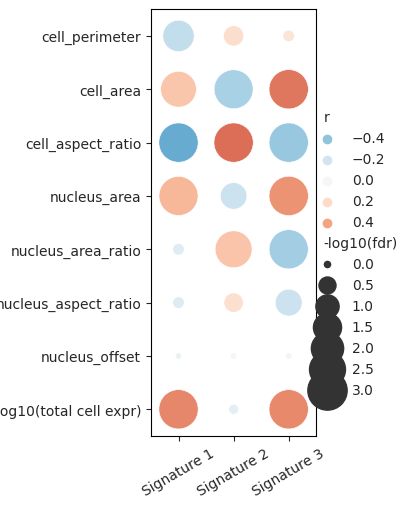

In [34]:
cell_corr = corr_loadings(
    cell_loadings,
    cell_measures,
    height=5,
    aspect=0.77,
)